<a href="https://colab.research.google.com/github/nadya-58/MIDRC_colab/blob/main/MIDR_BPR_with_lung_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gcloud config set project  bwh-midrc-rapid-res-1655321320

Updated property [core/project].


In [ ]:
from google.colab import auth
auth.authenticate_user()

MessageError: ignored

In [ ]:
#!gcloud auth login

In [ ]:
  project_name = "bwh-midrc-rapid-res-1655321320"
  bucket_name = "midrc-analysis-bwh"
  bucket_path = "bpr-results/"

In [ ]:
import os
import shutil
import glob
import json
import matplotlib.pyplot as plt
from matplotlib import transforms
from matplotlib.colors import ListedColormap
import numpy as np

In [ ]:
!pip install dicomweb-client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 3.0 MB/s 
     |████████████████████████████████| 2.0 MB 10.1 MB/s 
     |████████████████████████████████| 3.1 MB 40.9 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=8e2c7812c76fc17430338fd4373a2d15f865c9d88ba5ed2cbca95b5161da7ebb
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


In [ ]:
#install nrrd
!pip install pynrrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52.8 MB 226 kB/s 


In [ ]:
#Install Plastimatch

!sudo apt install plastimatch 
!echo $(plastimatch --version)

if os.path.isdir('/content/pyplastimatch'):
  try:
    shutil.rmtree('/content/pyplastimatch')
  except OSError as err:
    print("Error: %s : %s" % ("pyplastimatch", err.strerror)) 
# !git clone https://github.com/denbonte/pyplastimatch/ pyplastimatch
!git clone https://github.com/AIM-Harvard/pyplastimatch.git 

# from pyplastimatch import pyplastimatch as pypla
from pyplastimatch.pyplastimatch import pyplastimatch as pypla

Reading package lists... Done
Building dependency tree       
Reading state information... Done
plastimatch is already the newest version (1.7.0+dfsg.1-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
plastimatch version 1.7.0
Cloning into 'pyplastimatch'...
remote: Enumerating objects: 349, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 349 (delta 29), reused 91 (delta 29), pack-reused 257
Receiving objects: 100% (349/349), 55.58 MiB | 19.93 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [ ]:
!pip install git+https://github.com/JoHof/lungmask

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/JoHof/lungmask to /tmp/pip-req-build-tp7kwow4
  Running command git clone -q https://github.com/JoHof/lungmask /tmp/pip-req-build-tp7kwow4
     |████████████████████████████████| 1.1 MB 5.1 MB/s 
     |████████████████████████████████| 4.2 MB 30.6 MB/s 
  Created wheel for lungmask: filename=lungmask-0.2.11-py3-none-any.whl size=17456 sha256=f616f079e818014ea81b49ab38d106a23950503b97bd8b325c991d1eabb9ef8a
  Stored in directory: /tmp/pip-ephem-wheel-cache-18sh9_ov/wheels/b7/62/f7/fd172f57224a95cf73efec4a6029c8a78577dab75b949338d1
Successfully built lungmask


In [ ]:
%%bigquery --project=bwh-midrc-rapid-res-1655321320 ct_limited_open_a1_r1

WITH
  nlst_instances_per_series AS (
    SELECT
      DISTINCT(StudyInstanceUID),
      SeriesInstanceUID,
      COUNT(DISTINCT(SOPInstanceUID)) AS num_instances,
      COUNT(DISTINCT(ARRAY_TO_STRING(ImagePositionPatient,"/"))) AS position_count,
      COUNT(DISTINCT(ARRAY_TO_STRING(ImageOrientationPatient,"/"))) AS orientation_count,
      MIN(SAFE_CAST(SliceThickness AS float64)) AS min_SliceThickness,
      MAX(SAFE_CAST(SliceThickness AS float64)) AS max_SliceThickness,
      MIN(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS float64)) as min_SliceLocation, 
      MAX(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS float64)) as max_SliceLocation,
      STRING_AGG(DISTINCT(SAFE_CAST("LOCALIZER" IN UNNEST(ImageType) AS string)),"") AS has_localizer
    FROM
      bwh-midrc-rapid-res-1655321320.midrc_dicom_us
    WHERE
      (collection_id = "Open-R1" or collection_id = "Open-A1") and Modality = "CT"
    GROUP BY
      StudyInstanceUID,
      SeriesInstanceUID
      ), 
  nlst_values_per_series AS (
    SELECT 
    dicom_all.StudyInstanceUID AS StudyInstanceUID,
    ANY_VALUE(dicom_all.PatientID) AS PatientID,
    ANY_VALUE(dicom_all.SeriesInstanceUID) AS SeriesInstanceUID,
    ANY_VALUE(nlst_instances_per_series.num_instances) AS num_instances,
    ANY_VALUE(nlst_instances_per_series.max_SliceThickness) AS SliceThickness,
    ANY_VALUE((nlst_instances_per_series.max_SliceLocation - nlst_instances_per_series.min_SliceLocation)) AS PatientHeightScanned
  FROM
    idc-external-019.midrc_dicom_us.dicom_all AS dicom_all
  JOIN
    nlst_instances_per_series
  ON
    dicom_all.SeriesInstanceUID = nlst_instances_per_series.SeriesInstanceUID
  WHERE
    min_SliceThickness >= 1.5 
    AND max_SliceThickness <= 3.5 
    AND nlst_instances_per_series.num_instances > 100
    AND nlst_instances_per_series.num_instances/nlst_instances_per_series.position_count = 1
    AND nlst_instances_per_series.orientation_count = 1
    AND has_localizer = "false"
  GROUP BY
    StudyInstanceUID
  )
  SELECT 
    dicom_all.PatientID,
    dicom_all.StudyInstanceUID,
    dicom_all.SeriesInstanceUID,
    dicom_all.SOPInstanceUID,
    dicom_all.collection_id,
    dicom_all.PatientAge,
    dicom_all.PatientWeight,
    nlst_values_per_series.num_instances,
    nlst_values_per_series.SliceThickness,
    nlst_values_per_series.PatientHeightScanned
  FROM
    bwh-midrc-rapid-res-1655321320.midrc_dicom_us AS dicom_all
  JOIN
    nlst_values_per_series 
  ON
    dicom_all.SeriesInstanceUID = nlst_values_per_series.SeriesInstanceUID


ERROR:
 403 POST https://bigquery.googleapis.com/bigquery/v2/projects/bwh-midrc-rapid-res-1655321320/jobs: Access Denied: Project bwh-midrc-rapid-res-1655321320: User does not have bigquery.jobs.create permission in project bwh-midrc-rapid-res-1655321320.

(job ID: 6f7b1ae0-b6f9-413a-96ef-64a9bc86ab1c)

                                                    -----Query Job SQL Follows-----                                                    

    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |
   1:WITH
   2:  nlst_instances_per_series AS (
   3:    SELECT
   4:      DISTINCT(StudyInstanceUID),
   5:      SeriesInstanceUID,
   6:      COUNT(DISTINCT(SOPInstanceUID)) AS num_instances,
   7:      COUNT(DISTINCT(ARRAY_TO_STRING(ImagePositionPatient,"/"))) AS position_count,
   8:      COUNT(DISTINCT(ARRAY_TO_STRING(ImageOrientationPatient,"/"))) AS orientation_count,
   9:      MIN(SAFE_CAST(SliceThickness AS 

In [ ]:
ct_limited_open_a1_r1

,PatientID,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,collection_id,PatientAge,PatientWeight,num_instances,SliceThickness,PatientHeightScanned
0,10000364-1450691,2.16.840.1.114274.1818.52970058003623166638743...,2.16.840.1.114274.1818.51040563821980796451105...,2.16.840.1.114274.1818.46763215956351466621334...,Open-A1,069Y,111.0,108,2.5,267.500
1,10000364-928517,2.16.840.1.114274.1818.55876617153397017048056...,2.16.840.1.114274.1818.52653802425444338887397...,2.16.840.1.114274.1818.47756100641167134764683...,Open-A1,061Y,120.203,248,2.0,7.419
2,10000364-5793210,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,Open-A1,None,None,227,2.0,6.169
3,419639-008615,1.2.826.0.1.3680043.10.474.419639.774626438417...,1.2.826.0.1.3680043.10.474.419639.149051607502...,1.2.826.0.1.3680043.10.474.419639.207329004914...,Open-R1,070Y,None,145,2.5,360.000
4,10000364-1798403,2.16.840.1.114274.1818.48407566078342097453968...,2.16.840.1.114274.1818.51209421408939323841027...,2.16.840.1.114274.1818.50635933536631784065786...,Open-A1,048Y,121.927,181,1.5,270.000
...,...,...,...,...,...,...,...,...,...,...
53989,10000364-1199507,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,Open-A1,028Y,108.863,250,2.0,2.879
53990,10000364-2068455,2.16.840.1.114274.1818.51103257018976136311695...,2.16.840.1.114274.1818.55851575706841651611423...,2.16.840.1.114274.1818.56547574010280120226959...,Open-A1,043Y,97.523,250,1.5,16.414
53991,10000364-1199507,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,Open-A1,028Y,108.863,250,2.0,2.879
53992,10000364-1199507,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,Open-A1,028Y,108.863,250,2.0,2.879


In [ ]:
def download_series(study_instance_uid, series_instance_uid, sop_instance_uids, dest_dir):
  import pydicom
  token = !gcloud auth print-access-token
  token = token[0]

  PROJECT_ID="idc-external-019"
  REGION="us-central1"

  DATASET_ID="midrc"
  DICOM_STORE_ID="midrc-dicom"
  
  my_project = "idc-external-019"
  location = "us-central1"
  dataset_id = "midrc"
  dicom_store_id = "midrc-dicom"

  url = f"https://healthcare.googleapis.com/v1/projects/{my_project}/locations/{location}/datasets/{dataset_id}/dicomStores/{dicom_store_id}/dicomWeb"
  headers = {
      "Authorization" : "Bearer %s" % token
  }

  import dicomweb_client

  client = dicomweb_client.api.DICOMwebClient(url, headers=headers)

  idx=0
  for sop_instance_uid in sop_instance_uids:
    retrievedInstance = client.retrieve_instance(
                study_instance_uid=study_instance_uid,
                series_instance_uid=series_instance_uid,
                sop_instance_uid=sop_instance_uid)
    pydicom.filewriter.write_file(f"{dest_dir}/file{idx}.dcm", retrievedInstance)
    idx+=1

In [ ]:
from google.cloud import storage

storage_client = storage.Client(project = project_name)
#bucket = storage_client.get_bucket(bucket_name)

series_instance_uids = []

#blobs = storage_client.list_blobs(bucket)
blobs = storage_client.list_blobs(bucket_name, prefix=bucket_path, delimiter='/')
for blob in blobs:
    bn = blob.name
    bs = bn.split('.')
    if bs[-1] == 'json':
      bss = bn.split('/')[1]
      bs3 = bss.split('.')
      bs4 = '.'.join(bs3[:-1])
      series_instance_uids.append(bs4)

print(series_instance_uids[:10])

['1.2.826.0.1.3680043.10.474.419639.105799060738901793068313281334', '1.2.826.0.1.3680043.10.474.419639.106364025147079899289440200715', '1.2.826.0.1.3680043.10.474.419639.149051607502633615235577977952', '1.2.826.0.1.3680043.10.474.419639.189346812051260775638656981947', '1.2.826.0.1.3680043.10.474.419639.192916356998524553834723357563', '1.2.826.0.1.3680043.10.474.419639.198735019931123383691750806063', '1.2.826.0.1.3680043.10.474.419639.249044315484665760654506668895', '1.2.826.0.1.3680043.10.474.419639.259584978733948574762940092562', '1.2.826.0.1.3680043.10.474.419639.269534881585852761235289087419', '1.2.826.0.1.3680043.10.474.419639.272117657178318732150423166273']


In [ ]:
print(len(series_instance_uids))

495


In [ ]:
df = ct_limited_open_a1_r1
k=0

good_seriesuids = []

#series_instance_uids = ['1.2.826.0.1.3680043.10.474.419639.106364025147079899289440200715']

for seriesuid in series_instance_uids:
  #print(seriesuid)
  studyuids = list(set(df[df['SeriesInstanceUID']==seriesuid]['StudyInstanceUID'].tolist()))
  if len(studyuids)>0:
    k=k+1
    print(seriesuid)
    studyuid = studyuids[0]
    sops = df[ (df['StudyInstanceUID']==studyuid) & (df['SeriesInstanceUID']==seriesuid) ]['SOPInstanceUID'].tolist()
    print(len(sops))
    #download_series(studyuid, seriesuid, sops, path_downloaded)
    good_seriesuids.append(seriesuid)
print(k)

1.2.826.0.1.3680043.10.474.419639.105799060738901793068313281334
178
1.2.826.0.1.3680043.10.474.419639.149051607502633615235577977952
145
1.2.826.0.1.3680043.10.474.419639.192916356998524553834723357563
111
1.2.826.0.1.3680043.10.474.419639.198735019931123383691750806063
184
1.2.826.0.1.3680043.10.474.419639.272117657178318732150423166273
194
1.2.826.0.1.3680043.10.474.419639.281464894123439644671058369302
272
1.2.826.0.1.3680043.10.474.419639.334475370484806268089381726911
206
1.2.826.0.1.3680043.10.474.419639.336871778486950686179971404477
271
1.2.826.0.1.3680043.10.474.419639.337058107440810621229570649505
194
1.2.826.0.1.3680043.10.474.419639.337142866003655727331878751504
114
1.2.826.0.1.3680043.10.474.419639.939657231423501545181087708673
658
1.2.826.0.1.3680043.10.474.419639.995661493936010249470686852549
106
1.3.6.1.4.1.5962.99.1.1247991691.71736179.1616155726490.11471.0
997
1.3.6.1.4.1.5962.99.1.1247991691.71736179.1616155726490.1276.0
209
1.3.6.1.4.1.5962.99.1.1247991691.7173

In [ ]:
print(len(good_seriesuids))

202


In [ ]:
path_downloaded = '/content/downloaded_data'
path_nifti = '/content/nifti_data'
path_json =  '/content/json_data'
path_nrrd = '/content/nrrd_data'

for x in [path_downloaded, path_nifti, path_json, path_nrrd]:
  if os.path.isdir(x):
    try:
      shutil.rmtree(x)
    except OSError as err:
      print("Error: %s : %s" % (x, err.strerror))  
  os.mkdir(x)

In [ ]:
! rm -r /content/downloaded_data/

In [ ]:
path_downloaded

'/content/downloaded_data'

In [ ]:
df = ct_limited_open_a1_r1
k=0

good_seriesuids = ['1.3.6.1.4.1.5962.99.1.3492129840.282517718.1618399864692.46885.0']

for seriesuid in good_seriesuids:
  #print(seriesuid)
  studyuids = list(set(df[df['SeriesInstanceUID']==seriesuid]['StudyInstanceUID'].tolist()))
  if len(studyuids)>0:
    k=k+1
    print(seriesuid)
    studyuid = studyuids[0]
    sops = df[ (df['StudyInstanceUID']==studyuid) & (df['SeriesInstanceUID']==seriesuid) ]['SOPInstanceUID'].tolist()
    print(len(sops))
    download_series(studyuid, seriesuid, sops, path_downloaded)
    #good_seriesuids.append(seriesuid)
print(k)

1.3.6.1.4.1.5962.99.1.3492129840.282517718.1618399864692.46885.0
252


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py", line 396, in _make_request
    assert_header_parsing(httplib_response.msg)
  File "/usr/local/lib/python3.7/dist-packages/urllib3/util/response.py", line 72, in assert_header_parsing
    raise HeaderParsingError(defects=defects, unparsed_data=unparsed_data)
urllib3.exceptions.HeaderParsingError: [StartBoundaryNotFoundDefect(), MultipartInvariantViolationDefect()], unparsed data: ''
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py", line 396, in _make_request
    assert_header_parsing(httplib_response.msg)
  File "/usr/local/lib/python3.7/dist-packages/urllib3/util/response.py", line 72, in assert_header_parsing
    raise HeaderParsingError(defects=defects, unparsed_data=unparsed_data)
urllib3.exceptions.HeaderParsingError: [StartBoundaryNotFoundDefect(), MultipartInvariantViolationDefect()], unparsed data: ''
Traceback 

1


In [ ]:
# Convert image to nrrd and read as numpy array
import nrrd

file_path_nrrd = os.path.join(path_nrrd,  "ct.nrrd")
log_file_path_nrrd = os.path.join(path_nrrd, 'pypla.log')
convert_args_ct = {"input" : path_downloaded, "output-img" : file_path_nrrd}
verbose = True
pypla.convert(verbose = verbose, path_to_log_file = log_file_path_nrrd, **convert_args_ct)
# read nrrd CT
#ct, ctheader = nrrd.read(file_path_nrrd)
print(ct.shape)


Running 'plastimatch convert' with the specified arguments:
  --input /content/downloaded_data
  --output-img /content/nrrd_data/ct.nrrd
... Done.
(512, 512, 187)


In [ ]:
from lungmask import mask
import SimpleITK as sitk

input_image = sitk.ReadImage(file_path_nrrd)
segmentation = mask.apply(input_image) 

100%|██████████| 9/9 [00:00<00:00, 27.02it/s]


In [ ]:
print(segmentation.shape)

(252, 512, 512)


In [ ]:
s=np.swapaxes(segmentation,0,2 )

In [ ]:
print(s.shape)
print(ct.shape)

(512, 512, 252)
(512, 512, 187)


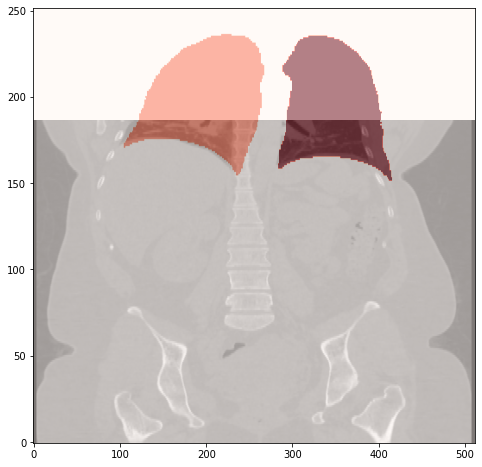

In [ ]:
# Plot CT and lung segmentation 

plt.figure(figsize=[8,8])
plt.imshow(ct[:,300,:].T, cmap='gray', aspect=2, origin = "lower")
plt.imshow(s[:,300,:].T, cmap='Reds', alpha=0.5, aspect=2, origin = "lower")

In [ ]:
# Define slices with segmented lungs

l1_list = list(np.array(np.where((np.sum((s==1),axis=(0,1))>0)==True)[0]).astype(int))
l1_min = min(l1_list)
l1_max = max(l1_list)
#print(l1_min, l1_max)

l2_list = list(np.array(np.where((np.sum((s==2),axis=(0,1))>0)==True)[0]).astype(int))
l2_min = min(l2_list)
l2_max = max(l2_list)
#print(l2_min, l2_max)


lmin_all = min([l1_min, l1_max,l2_min, l2_max])
lmax_all = max([l1_min, l1_max,l2_min, l2_max])
llist_out = [lmin_all, lmax_all]
lungs = list(range(lmin_all, lmax_all+1, 1))

print(llist_out)
print(lungs)

[155, 177]
[155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177]


In [ ]:
# Use BPR json for slice classification  

file_json = '%s.json' % seriesuid
cmd = "gsutil cp gs://%s/%s%s  %s" % (bucket_name, bucket_path, file_json, path_json)
print(cmd)
os.system(cmd)

fileObject = open("%s/%s" % (path_json, file_json), "r")
jsonContent = fileObject.read()
aList = json.loads(jsonContent)

for (bodypart, zlist) in aList['body part examined'].items():
    print(bodypart, zlist)

NameError: ignored

In [ ]:
for seriesuid in series_instance_uids:
  

  file_json = '%s.json' % seriesuid
  cmd = "gsutil cp gs://%s/%s%s  %s" % (bucket_name, bucket_path, file_json, path_json)
  print(cmd)
  os.system(cmd)

gsutil cp gs://midrc-analysis/bpr-results/1.2.826.0.1.3680043.10.474.419639.105799060738901793068313281334.json  /content/json_data
gsutil cp gs://midrc-analysis/bpr-results/1.2.826.0.1.3680043.10.474.419639.106364025147079899289440200715.json  /content/json_data
gsutil cp gs://midrc-analysis/bpr-results/1.2.826.0.1.3680043.10.474.419639.149051607502633615235577977952.json  /content/json_data
gsutil cp gs://midrc-analysis/bpr-results/1.2.826.0.1.3680043.10.474.419639.189346812051260775638656981947.json  /content/json_data
gsutil cp gs://midrc-analysis/bpr-results/1.2.826.0.1.3680043.10.474.419639.192916356998524553834723357563.json  /content/json_data
gsutil cp gs://midrc-analysis/bpr-results/1.2.826.0.1.3680043.10.474.419639.198735019931123383691750806063.json  /content/json_data
gsutil cp gs://midrc-analysis/bpr-results/1.2.826.0.1.3680043.10.474.419639.249044315484665760654506668895.json  /content/json_data
gsutil cp gs://midrc-analysis/bpr-results/1.2.826.0.1.3680043.10.474.419639.

In [ ]:
k = 0

for seriesuid in series_instance_uids:

  file_json = seriesuid + '.json'

  fileObject = open("%s/%s" % (path_json, file_json), "r")
  jsonContent = fileObject.read()
  aList = json.loads(jsonContent)

  bp = aList['body part examined']
  ch = bp['chest']
  l = len(ch)
  if l > 0:
    k=k+1

print(k)

479
